# Машинное обучение
## ВМК МГУ, весна 2015/2016
## Лабораторная работа 1. Линейные модели

ФИО: Драпак С. Н.

Группа: 317

Данное задание посвящено применению линейных моделей в задачах классификации и регрессии. Вы научитесь:
* делать one-hot-кодирование категориальных признаков
* обучать логистическую и линейную регрессию
* отбирать признаки с помощью LASSO
* вычислять метрики качества классификации и регрессии
* выбирать лучший классификатор при ограничениях на точность или полноту
* калибровать вероятности
* реализовывать градиентный спуск (если захотите)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Часть 1. Научные гранты в Австралии

![](http://imgur.com/cBdDBO3.jpg)

В данной части мы будем работать с задачей "Predict Grant Applications" (https://www.kaggle.com/c/unimelb/data), где для заявки на грант требуется предсказать, одобрят её или нет. Будем использовать лишь 40 признаков из имеющихся 249. Файлы для работы можно найти по ссылкам:
* https://db.tt/iYzRzQYP (обучение)
* https://db.tt/NGSHb5Qs (контроль)

#### Задание 1
Считайте обучающую и контрольную выборки из файлов с помощью pd.read_csv. Выделите целевую переменную (Grant.Status) в отдельный вектор.

In [65]:
data_train = pd.read_csv('unimel_train.csv')
data_test = pd.read_csv('unimel_test.csv')
y_train = data_train['Grant.Status']
data_train = data_train.drop(['Grant.Status'], axis=1)
y_test = data_test['Grant.Status']
data_test = data_test.drop(['Grant.Status'], axis=1)

#### Задание 2
В этом задании мы приведем данные к виду, пригодному для обучения линейных классификаторов. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду. Также надо устранить пропуски в данных.

В первую очередь поймем, зачем здесь нужно масштабирование. Нарисуем распределение трех признаков.

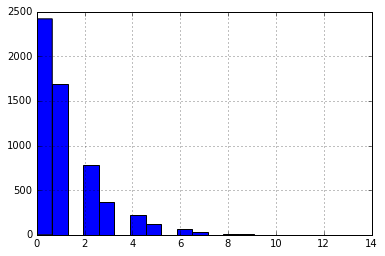

In [10]:
data_train['Number.of.Successful.Grant.1'].hist(bins=20)
plt.show()

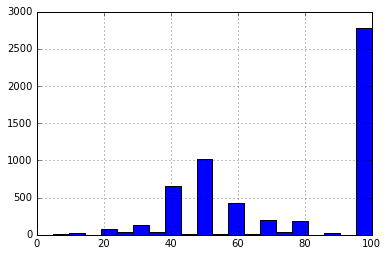

In [11]:
data_train['RFCD.Percentage.1'].hist(bins=20)
plt.show()

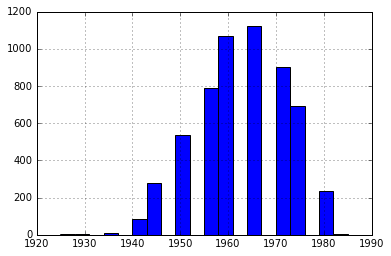

In [12]:
data_train['Year.of.Birth.1'].hist(bins=20)
plt.show()

Какую проблему вы наблюдаете на этих графиках? Как масштабирование поможет её исправить?

У каждого признака свой масштаб, это ведет к тому, что например, при решение задачи оптимизации(для линейных методов) у нас будут образовываться сильно вытянутые "ямы", и при выполнение градиентного шага мы будем просто перескакивать их не попадая при этом в минимум(хотел нарисовать картинку в пэйнте, но оказалось, что это совсем не мое). Для метрических методов тут тоже все плохо, одниковые разбросы в значениях разных признаков могут нести разные смысловые нагрузки. У деревье все ок. Любите деревья.

В наших данных есть пропуски. Ответьте на вопросы:
1. Сколько всего пропущенных элементов в таблице с обучающей выборкой?
2. Сколько объектов имеют хотя бы один пропуск?
3. Сколько признаков имеют хотя бы одно пропущенное значение?

In [11]:
data_train.isnull().sum().sum()

26843L

In [18]:
print sum(data_train.isnull().sum(axis=1) != 0)
print data_train.shape[0]

5879
6095


In [24]:
print sum(data_train.isnull().sum(axis=0) != 0)
print data_train.shape[1]

38
39


И того получаем, что в таблице 26843 пропусков. При этом они присутствуют в описании 5879 объектов выборки. То есть почти во всех. При этом все кроме 1го признака имеют пропуски.

Большинство признаков в нашем датасете являются категориальными. Типичным подходом к работе с ними является бинарное, или one-hot-кодирование (также есть подход со счётчиками, который мы уже применяли в прошлых работах). Для начала потренируемся делать бинарное кодирование на трех игрушечных объектах.

In [25]:
simple_data = pd.DataFrame({'City': ['Msk', 'SPb', 'Msk'], 'Weather': ['good', 'bad', 'worst']})
simple_data.head()

,City,Weather
0,Msk,good
1,SPb,bad
2,Msk,worst


In [26]:
# преобразуем каждый объект в dict
simple_data_dict = simple_data.T.to_dict().values()
print simple_data_dict

[{'City': 'Msk', 'Weather': 'good'}, {'City': 'SPb', 'Weather': 'bad'}, {'City': 'Msk', 'Weather': 'worst'}]


In [28]:
# делаем one-hot-кодирование
from sklearn.feature_extraction import DictVectorizer
transformer = DictVectorizer(sparse=False)
print transformer.fit_transform(simple_data_dict)
# примените здесь DictVectorizer к simple_data_dict, получите бинарную матрицу и выведите её

[[ 1.  0.  0.  1.  0.]
 [ 0.  1.  1.  0.  0.]
 [ 1.  0.  0.  0.  1.]]


Реализуйте функцию transform_data, которая принимает на вход DataFrame с признаками, объекты классов StandardScaler и DictVectorizer и булеву переменную is_test (True, если обрабатывает тестовую выборку и False, если обучающую). В функции должны выполняться следующие шаги:
1. Замена пропущенных значений на нули для вещественных признаков и на строки 'nan' для категориальных. Используйте для выполнения замены функцию fillna. Имена всех вещественных переменных перечислены в numeric_cols.
2. Масштабирование вещественных признаков с помощью StandardScaler (метод fit_transform, если is_test == False, и метод transform в противном случае).
3. One-hot-кодирование категориальных признаков с помощью DictVectorizer (метод fit_transform, если is_test == False, и метод transform в противном случае).

Метод должен возвращать tuple из трех элементов: преобразованной выборки, объекта StandardScaler и объекта DictVectorizer. Преобразованная выборка должна состоять из масштабированных вещественных признаков и закодированных категориальных (исходные признаки не должны в ней остаться).

In [3]:
def transform_data(data, scaler, transformer, is_test):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    categorial_cols = list(set(data.columns) - set(numeric_cols))
    #print categorial_cols
    
    data[numeric_cols] = data[numeric_cols].fillna(0) 
    data[categorial_cols] = data[categorial_cols].fillna('nan').astype(str)
    #print data.shape
    
    
    if is_test:
        data[numeric_cols] = scaler.transform(data[numeric_cols])
        one_hot = transformer.transform(data[categorial_cols].T.to_dict().values())
        data = data.drop(categorial_cols, axis=1)
        data = pd.concat((data, pd.DataFrame(one_hot.toarray())), axis=1)
    else:
        data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
        one_hot = transformer.fit_transform(data[categorial_cols].T.to_dict().values())        
        data = data.drop(categorial_cols, axis=1)    
        data = pd.concat((data, pd.DataFrame(one_hot.toarray())), axis=1)
        #print data.shape
        
    return data, scaler, transformer
    

Применяем функцию к данным:

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
scaler = StandardScaler()
transformer = DictVectorizer()
X, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test, _, _ = transform_data(data_test, scaler, transformer, True)

Сколько признаков у вас получилось после преобразования?

In [5]:
print X.shape[1]

11734


#### Задание 3
Подберите лучшее значение параметра регуляризации C для логистической регрессии с L2-регуляризатором (sklearn.linear_model.LogisticRegression) с помощью кросс-валидации по 5 блокам. В качестве метрики качества используйте AUC-ROC. Сетка для перебора указана ниже. По итогам кросс-валидации укажите лучшее значение параметра регуляризации. Обучите классификатор с этим параметром на всей обучающей выборке и найдите качество (AUC-ROC) на тестовой выборке.

In [10]:
from sklearn.cross_validation import KFold
cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=241)

In [11]:
# вам пригодятся функции cross_val_score или GridSearchCV; используйте в них объект cv в качестве генератора разбиений
C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
clf = LogisticRegression()
params = {'C':C_grid, 'penalty':['l2']}
gs = GridSearchCV(estimator=clf, param_grid=params, cv=cv, verbose=1, scoring='roc_auc')
#print data_train.shape, y_train.shape
gs.fit(X, y_train)
print gs.best_params_
print gs.best_score_


Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'penalty': 'l2', 'C': 0.1}
0.882392037362


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   38.9s finished


Попробуем теперь логистическую регрессию с L1-регуляризатором (penalty='l1'). Выведите число ненулевых коэффициентов (clf.coef\_) при каждом значении параметра регуляризации из сетки.

In [12]:
params = {'C':C_grid, 'penalty':['l1']}
gs = GridSearchCV(estimator=clf, param_grid=params, cv=cv, verbose=1, scoring='roc_auc')
#print data_train.shape, y_train.shape
gs.fit(X, y_train)
print gs.best_params_
print gs.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'penalty': 'l1', 'C': 1.0}
0.880473529101


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   39.8s finished


In [13]:
for C in C_grid:
    clf = LogisticRegression(penalty='l1', C=C)
    clf.fit(X, y_train)
    #print 'with C = ' + str(C) + "# zero coef: "
    #print clf.coef_
    print np.sum(clf.coef_ != 0.)

0
9
58
669
2428
2969


Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01? Сколько для достижения такого качества ей нужно признаков?

In [14]:
from sklearn.metrics import roc_auc_score
clf = LogisticRegression(penalty='l1', C=0.01)
clf.fit(X, y_train)
preds_l1 = clf.predict_proba(X_test)
print roc_auc_score(y_test, preds_l1[:, 1])

0.852545565192


Получается, что на тестовой выборке с l1 регуляризатором и параметром С = 0.01 используя лишь 9 признаков из более чем 11 тысяч мы получаем ROC-AUC 0.852. Заметим, что лучшее качество все же достигается при C = 0.1 и l2 регуляризации и оно на 0.03 выше.

#### Задание 4
В этом задании мы внимательно рассмотрим различные аспекты качества классификатора. Для этого возьмите классификатор с L2-регуляризатором с лучшим значением параметра регуляризации (вы его нашли в предыдущем задании), обучите на полной обучающей выборке и найдите предсказания вероятностей на тесте. Далее будем работать только с этими прогнозами.

In [15]:
clf = LogisticRegression(penalty='l2', C=0.1)
clf.fit(X, y_train)
preds = clf.predict_proba(X_test)

Посчитайте AUC-ROC, AUC-PR (average_precision_score) и log-loss для прогнозов.

In [18]:
from sklearn.metrics import average_precision_score, log_loss
print roc_auc_score(y_test, preds[:, 1])
print average_precision_score(y_test, preds[:, 1])
print log_loss(y_test, preds[:, 1])

0.880346701167
0.8387555666
0.442736821328


Нарисуйте ROC- и PR-кривые. Не забудьте подписать оси.

In [33]:
from sklearn.metrics import precision_recall_curve, roc_curve
fpr, tpr, _ = roc_curve(y_test, preds[:, 1])
precision, recall, th = precision_recall_curve(y_test, preds[:, 1])

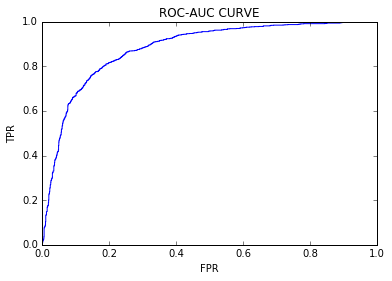

In [29]:
plt.xlabel('FPR')    
plt.ylabel('TPR')
plt.title('ROC-AUC CURVE')
plt.plot(fpr, tpr)
plt.show()

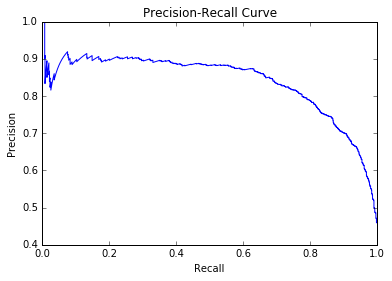

In [32]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.plot(recall, precision)
plt.show()

Допустим, мы хотим построить классификатор, который будет находить не менее 90% успешных грантов. Соответственно, имеем нижнюю границу 90% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога? Для получения ответа проанализируйте массивы, возвращаемые функцией metrics.precision_recall_curve.

In [38]:
max_pres = 0.0
opt_recall = 0.0
opt_th = 0
for i in range(th.shape[0]):
    if recall[i] > 0.9:
        if precision[i] > max_pres:
            max_pres = precision[i]
            opt_recall = recall[i]
            opt_th = th[i]
print max_pres, opt_recall, opt_th

0.701948051948 0.900083263947 0.314959228603


Получили, что при заданном значение recall = 0.9 лучшая точность 0.702 достигается при значении порога 0.315

Возьмите классификатор с порогом из предыдущего пункта и подсчитайте для него F-меру. Почему она получилась маленькой, несмотря на высокую полноту?

In [42]:
from sklearn.metrics import f1_score
bin_preds = (preds[:, 1] > opt_th).astype(int)
print f1_score(y_test, bin_preds)

0.788321167883


Странный какой-то вопрос. Что-то подсказывает, что это из-за того, что получилась маленькая точность. А она получилось такой, потому что алгоритм так себе.

Допустим, что университету важно подавать как можно меньше заявок, которые окажутся неуспешными — они очень плохо влияют на репутацию. Установим нижнюю границу на точность 80%. Какую максимальную полноту при этом можно обеспечить? При каком пороге?

In [45]:
opt_pres = 0.0
max_recall = 0.0
opt_th = 0
for i in range(th.shape[0]):
    if precision[i] > 0.8:
        if recall[i] > max_recall:
            max_recall = recall[i]
            opt_precsision = precision[i]
            opt_th = th[i]
print max_recall, opt_precsision, opt_th

0.776019983347 0.800687285223 0.530105316112


Получили, что при заданной точности 0.8 лучший показатель полноты - 0.776 при пороге 0.53

#### Задание 5
В этом задании мы научимся оценивать способность классификатора предсказывать вероятности, а также разберемся с калибровкой.

Начнем с калибровочных кривых. Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [69]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        #print np.sum(y_test[(preds >= l) & (preds < r)])
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)])/float(y_test[(preds >= l) & (preds < r)].shape[0]))
    #print bin_middle_points
    #print bin_real_ratios
    #print 
    plt.plot(bin_middle_points, bin_real_ratios)

Проверим её работу на логистической регрессии (поменяйте имена переменных, если это необходимо). Получилась ли почти диагональная калибровочная кривая?

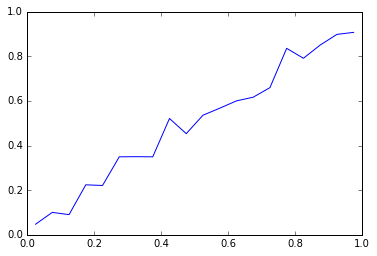

In [70]:
clf = LogisticRegression(C=1.0)
clf.fit(X, y_train)
preds = clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

Получилось более-менее диагонально

Заодно обратим внимание на то, как часто классификатор выдает те или иные вероятности.

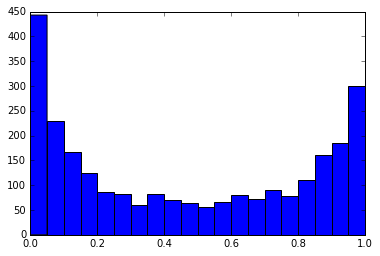

In [71]:
plt.hist(preds, bins=20)
plt.show()

Обучим теперь классификатор с кусочно-линейной функцией потерь (hinge loss, как в SVM).

In [72]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
clf.fit(X, y_train)
preds = clf.decision_function(X_test)
preds = 1.0 / (1.0 + np.exp(-preds))

Изучите распределение ответов классификатора. Чем оно отличается от распределения у логистической регрессии? Чем вы можете объяснить это?

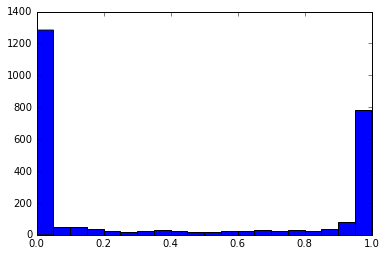

In [73]:
plt.hist(preds, bins=20)
plt.show()

Получаем, что вероятности сконцентрированы рядом с 0 и 1. Логистическая функция потерь значительно более гладкая, то есть при отступе < 0 она всюду ниже функции Хинжа, а при отступе > 0 всюду выше, при этом в силу особенности функции Хинжа при всех отсупах > 1 значения функции 0, отсюда и большое число нулевых значений. 

Нарисуем калибровочную кривую. Видите ли вы какие-либо проблемы в ней?

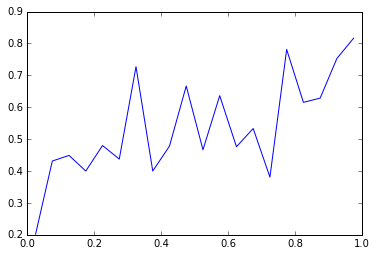

In [75]:
plot_calibration_curve(y_test, preds)

Она значительно менее похожа на диагональную по сравнению с результатом логистической регрессии

Попробуем откалибровать вероятности. Грубо говоря, это процедура, которая для каждого отрезка $[a_i, b_i]$ строит преобразование, которое корректирует вероятности в нем, приводя тем самым калибровочную кривую к диагональной форме.

Воспользуйтесь классом sklearn.calibration.CalibratedClassifierCV для калибровки вероятностей на обучении, и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

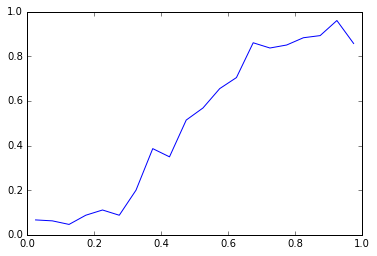

In [77]:
from sklearn.calibration import CalibratedClassifierCV
calibr_clf = CalibratedClassifierCV(clf)
calibr_clf.fit(X, y_train)
preds = calibr_clf.predict_proba(X_test)
plot_calibration_curve(y_test, preds[:, 1])

Ну вроде больше похоже на правду

#### Задание 6
Здесь вы можете вставить вашу любимую картинку про Австралию.

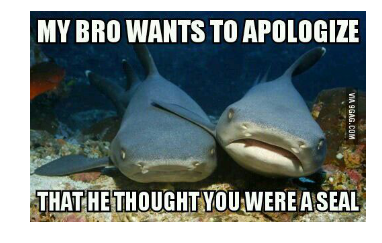

In [5]:
img = mpimg.imread('Shark-mistake.jpg')
plt.axis('off')
imgplot = plt.imshow(img)

## Часть 2. Градиентный спуск своими руками
**(опциональная часть, за правильное выполнение к оценке добавляется 3 балла)**

В этой части вам предстоит самостоятельно реализовать градиентный спуск для логистической функции потерь — то есть, по сути, собственными руками обучить логистическую регрессию. Будем использовать данные из предыдущей части.

Добавьте к обучающей и тестовой выборкам единичный признак. Переведите значения целевого вектора в множество $\{-1, +1\}$.

In [14]:
y_test[y_test == 0] = -1
y_train[y_train == 0] = -1
X_test['const'] = np.ones(X_test.shape[0])
X['const'] = np.ones(X.shape[0])

Для начала реализуйте функции, которые вычисляют функционал, его градиент, а также прогнозы модели.

In [9]:
# возвращает вектор предсказанных вероятностей для выборки X
def make_pred(X, w):
    return 1.0 / (1.0 + np.exp(-X.dot(w)))

In [41]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

In [34]:
# возвращает значение логистического функционала для выборки (X, y) и вектора весов w
def get_func(w, X, y):
    tmp = sigmoid(X.dot(w))
    return np.sum(-y * np.log(tmp) - (1-y)*np.log(1 - np.log(tmp)))

In [6]:
# возвращает градиент логистического функционала для выборки (X, y) и вектора весов w
def get_grad(w, X, y):
    delta = sigmoid(X.dot(w)) - y
    return delta.T.dot(X)

Теперь реализуйте градиентный спуск (не стохастический). Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В градиентном спуске должно выполняться не более max_iter итераций.

In [25]:
def grad_descent(X, y, step_size, max_iter):
    #print type(weights)
    obj_val = []
    w = np.random.rand(X.shape[1])/100.0
    for i in range(max_iter):
        w -= step_size * get_grad(w, X, y)
        #print w
        #print get_func(w, X, y)
        obj_val.append(get_func(w, X, y))
    return w, obj_val        

Запустите градиентный спуск для значений размера шага из набора [0.001, 1, 10]. Нарисуйте кривые зависимости значения функционала от номера итерации. Проанализируйте их. Вычислите AUC-ROC на тестовой выборке для лучшего из обученных вариантов.

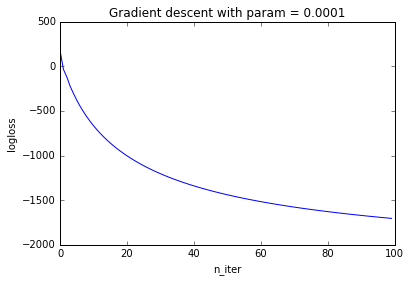

roc-auc with param = 0.0001
0.868645522027


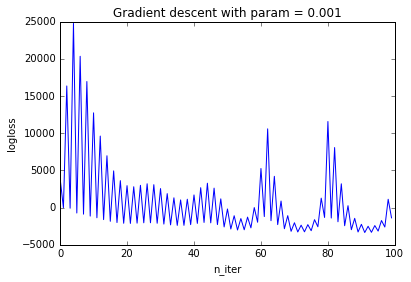

roc-auc with param = 0.001
0.86494611431


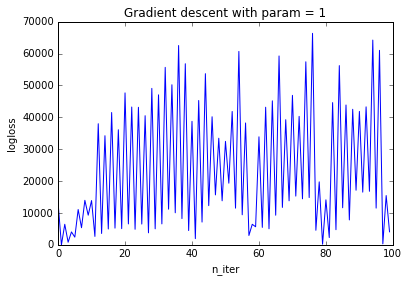

roc-auc with param = 1
0.678496790918


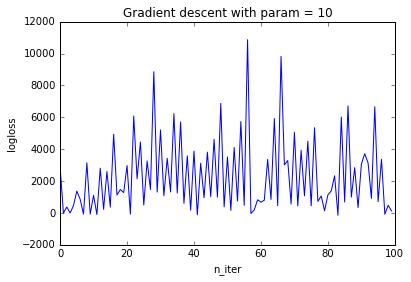

roc-auc with param = 10
0.675187461818


In [40]:
from sklearn.metrics import roc_auc_score
for step in [0.0001, 0.001, 1, 10]:
    w, obj = grad_descent(X, y_train, step, 100)
    plt.plot(obj)
    plt.title('Gradient descent with param = ' + str(step))
    plt.xlabel('n_iter')
    plt.ylabel('logloss')
    plt.show()
    preds = make_pred(X_test, w)
    print 'roc-auc with param = ' + str(step)
    print roc_auc_score(y_test, preds)

Пришлось добавить значение шага 0.0001 по крайней мере чтобы убедиться, что метод работает нормально. Хотя мы и поучили, что при этом шаге выйгрыш у версии с шагом 0.001 не велика, это лишь только потому что нам повезло и мы остановились на удачной итерации. Остальные варианты расходятся еще более фатально и функционал в итоге принимает очень высоки значения.

Теперь реализуйте стохастический градиентный спуск. Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В стохастическом градиентном спуске должно выполняться не более max_iter итераций.

In [56]:
def sgd(X, y, step_size, max_iter):
    batch_size = X.shape[0]/5
    obj_val = []
    w = np.random.rand(X.shape[1])/100.0
    indeces = np.array(range(X.shape[0]))
    for i in range(max_iter):
        np.random.shuffle(indeces)
        ind = indeces[:batch_size]
        w -= step_size * get_grad(w, X.iloc[ind, :], y[ind])
        #print w
        #print get_func(w, X, y)
        obj_val.append(get_func(w, X, y))
    return w, obj_val

Подберите размер шага, при котором SGD будет сходиться. Нарисуйте график сходимости. Вычислите AUC-ROC на тестовой выборке.

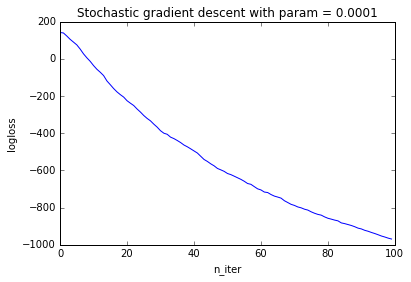

roc-auc with param = 0.0001
0.846012706597


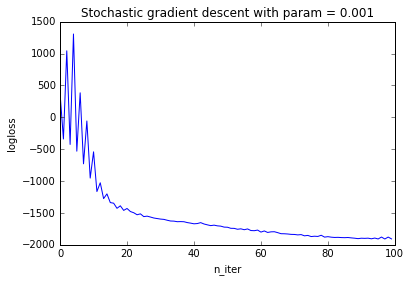

roc-auc with param = 0.001
0.871218330806


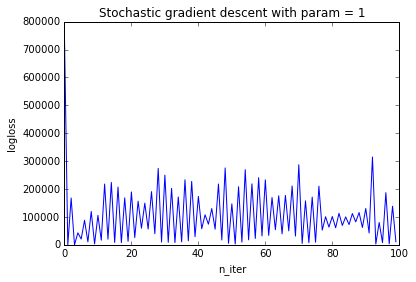

roc-auc with param = 1
0.698911494906


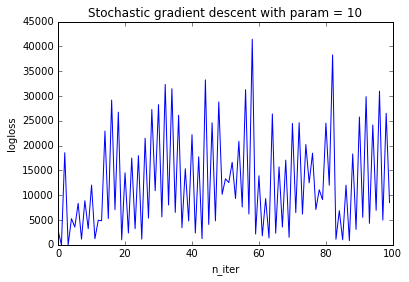

roc-auc with param = 10
0.770011357391


In [57]:
for step in [0.0001, 0.001, 1, 10]:    
    w, obj = sgd(X, y_train, step, 100)
    plt.plot(obj)
    plt.title('Stochastic gradient descent with param = ' + str(step))
    plt.xlabel('n_iter')
    plt.ylabel('logloss')
    plt.show()
    preds = make_pred(X_test, w)
    print 'roc-auc with param = ' + str(step)
    print roc_auc_score(y_test, preds)

В этот раз параметр 0.001 оказался оптимальным, причем он обогнал также все варианты с не стохастическим градиентом.

А теперь самое сложное: заново сформируйте выборку с помощью transform_data, но теперь не масштабируйте вещественные признаки. Запустите на этой выборке градиентный спуск. Что вы наблюдаете? Удается ли достичь такого же качества, как и при использовании масштабирования?

In [60]:
def transform_data2(data, transformer, is_test):
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    categorial_cols = list(set(data.columns) - set(numeric_cols))
    #print categorial_cols
    
    data[numeric_cols] = data[numeric_cols].fillna(0) 
    data[categorial_cols] = data[categorial_cols].fillna('nan').astype(str)
    #print data.shape
    
    
    if is_test:
        one_hot = transformer.transform(data[categorial_cols].T.to_dict().values())
        data = data.drop(categorial_cols, axis=1)
        data = pd.concat((data, pd.DataFrame(one_hot.toarray())), axis=1)
    else:
        one_hot = transformer.fit_transform(data[categorial_cols].T.to_dict().values())        
        data = data.drop(categorial_cols, axis=1)    
        data = pd.concat((data, pd.DataFrame(one_hot.toarray())), axis=1)
        #print data.shape
        
    return data, transformer

In [66]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
data_train = pd.read_csv('unimel_train.csv')
data_test = pd.read_csv('unimel_test.csv')
y_train = data_train['Grant.Status']
data_train = data_train.drop(['Grant.Status'], axis=1)
y_test = data_test['Grant.Status']
data_test = data_test.drop(['Grant.Status'], axis=1)
transformer = DictVectorizer()
X_no_scale, transformer = transform_data2(data_train, transformer, False)
X_test_no_scale, _ = transform_data2(data_test, transformer, True)

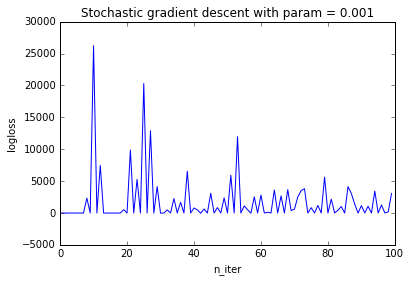

roc-auc with param = 0.001
0.50760756499


In [67]:
for step in [0.001]:    
    w, obj = sgd(X_no_scale, y_train, step, 100)
    plt.plot(obj)
    plt.title('Stochastic gradient descent with param = ' + str(step))
    plt.xlabel('n_iter')
    plt.ylabel('logloss')
    plt.show()
    preds = make_pred(X_test_no_scale, w)
    print 'roc-auc with param = ' + str(step)
    print roc_auc_score(y_test, preds)

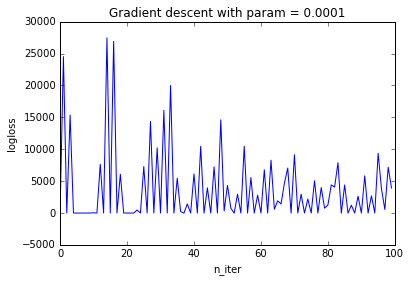

roc-auc with param = 0.0001
0.498610989897


In [68]:
for step in [0.0001]:
    w, obj = grad_descent(X_no_scale, y_train, step, 100)
    plt.plot(obj)
    plt.title('Gradient descent with param = ' + str(step))
    plt.xlabel('n_iter')
    plt.ylabel('logloss')
    plt.show()
    preds = make_pred(X_test_no_scale, w)
    print 'roc-auc with param = ' + str(step)
    print roc_auc_score(y_test, preds)

Выше уже обсуждались причины того что мы получили в последнем эксперименте

Здесь вы можете поделиться своими мыслями по поводу этой части.

Срочно нужен еще один кафедральный курс где мы будем трейнить разными градиентными спусками еще какую-нибудь линейную модель(благо выбор велик)

## Часть 3. Линейная регрессия на простом примере

В этой части мы очень кратко разберемся с линейной регрессией и измерением качества ее прогнозов. Будем использовать датасет diabetes.

In [2]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
import pandas as pd
data = datasets.load_diabetes()
X, X_test, y, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

Обучите линейную регрессию с L2-регуляризатором, подобрав лучшее значение параметра регуляризации на тестовой выборке. Используйте MSE в качестве функционала качества. При каком значении этого параметра достигается наилучшее качество?

In [6]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import numpy as np
alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
scl = StandardScaler()
X = np.hstack((X, np.ones((X.shape[0], 1))))
X_test = np.hstack((X_test,np.ones((X_test.shape[0], 1))))
#X_norm = scl.fit_transform(X)
#X_test_norm = scl.transform(X_test)
for alpha in alpha_grid:
    regressor = Ridge(alpha=alpha)
    regressor.fit(X, y)
    preds = regressor.predict(X_test)
    print 'with alpha = ' + str(alpha)
    print mean_squared_error(y_test, preds)

with alpha = 0.001
3120.09020578
with alpha = 0.01
3107.38818648
with alpha = 0.1
3096.03015101
with alpha = 1.0
3399.40482339
with alpha = 10.0
4577.48210429
with alpha = 100.0
5210.22019186


In [7]:
print X.shape, X_test.shape

(309, 13) (133, 13)


Вычислите для лучшей из моделей RMSE и коэффициент детерминации (r2_score) на тестовой выборке. Что вы можете сказать о значении коэффицинта детерминации? Насколько данная модель близка к оптимальной?

In [8]:
best_regr = Ridge(alpha = 0.01)
best_regr.fit(X, y)
preds = best_regr.predict(X_test)
print np.sqrt(mean_squared_error(preds, y_test)), r2_score(preds, y_test)

55.7439520171 0.0467953182875


Ну, модель конечно так себе получилось, видимо данных маловато да и зависимости так себе, по крайней мере они точно не похожи на линейные.